## Knowledge Graph Exploration

Reference: https://github.com/bdmarius/python-knowledge-graph

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
from lxml import etree
  
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#xml parser
def get_content():
    tree=ET.parse("ABSA16_Laptops_Train_English_SB2.xml")
    root = tree.getroot()
    text_list = []
    opinion_list = []
    for review in root.findall('Review'):
        text_string=""
        opinion_inner_list=[]
        for sent in review.findall('./sentences/sentence'):
            text_string= text_string+ " "+ sent.find('text').text
        text_list.append(text_string)
        for opinion in review.findall('./Opinions/Opinion'):
            opinion_dict = {
                opinion.get('category').replace('#','_'): opinion.get('polarity')
            }
            opinion_inner_list.append(opinion_dict)
        opinion_list.append(opinion_inner_list)
    return text_list,opinion_list

In [3]:
text, opinion = get_content()

### Create knowledge graph

Generate graph from triples.
Triples are of the form: <em><b>subject predicate/relation object</b></em><br>
    For instance, for the sentence,<em>Laptop has a very low price</em>.<br>
    Triples will be: <em><b>Subject</b>:Laptop</em> <em><b>Relation</b>:has a</em> <em><b>Object</b>:very low price</em>
    <br>Based on the rules, we can modify the formation of subject, predicates and object.

In [4]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))  # create a pipe-line 
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]  # extract a sentences aranging into appropriate format

In [5]:
def printToken(token):
    print(token.text, "->", token.dep_)

In [6]:
def appendChunk(original, chunk):
    return original + ' ' + chunk

In [7]:
def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]  # very basic rules
    return any(subs in token.dep_ for subs in deps)

In [8]:
def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

In [9]:
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

In [14]:
def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

In [15]:
def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

In [16]:
sentences = getSentences(text[4])

In [17]:
text[4]

' So far, a great product. High price tag, however. Still trying to learn how to use it.'

So -> advmod
far -> advmod
, -> punct
a -> det
great -> amod
product -> ROOT
. -> punct
 , great product , 
High -> amod
price -> compound
tag -> ROOT
, -> punct
however -> advmod
. -> punct
 , high tag , 
Still -> advmod
trying -> ROOT
to -> aux
learn -> xcomp
how -> advmod
to -> aux
use -> xcomp
it -> dobj
. -> punct
 , try , it


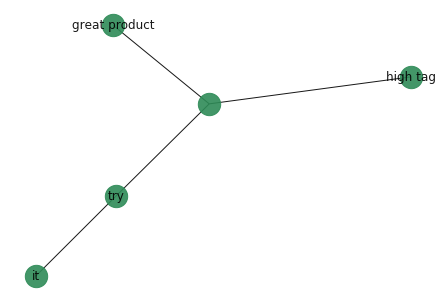

In [18]:

nlp_model = spacy.load('en_core_web_sm')

triples = []
# print (text)
for sentence in sentences:
    triples.append(processSentence(sentence))

printGraph(triples)